In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
random.seed(7)
from sklearn.metrics import mean_absolute_error

In [2]:
def ptime():
    print(datetime.datetime.now().time())
    return time.time()
start = ptime()
execution_time = ptime() - start
def ptime2(execution_time):
    print(f'{round(execution_time, 6)}s')
ptime2(execution_time)

12:16:00.325009
12:16:00.325284
9.4e-05s


In [3]:
def read_dataset(path):
    start = ptime()
    gc.collect()
    df = pd.read_csv(path)#change
    print(df.shape)
    df = df.dropna()
    print(df.shape)
    execution_time = ptime() - start
    ptime2(execution_time)
    return df

In [4]:
def reduce_mem_usage(df):
    start = ptime()
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.6f} MB'.format(start_mem))
    
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    for col in features:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    execution_time = ptime() - start
    ptime2(execution_time)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.6f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def mae(X_to_test, y_to_test, model_to_test):
    start = ptime()
    y_pred_test = model_to_test.predict(X_to_test)
    mae =  mean_absolute_error(y_to_test, y_pred_test)
    execution_time = ptime() - start
    ptime2(execution_time)
    return mae

In [6]:
df = read_dataset('../data/train_FE.csv')

12:16:10.174148
(4446965, 37)
(4446965, 37)
12:16:40.049640
29.87545s


In [7]:
df = reduce_mem_usage(df)
df.shape

12:16:50.644944
Memory usage of dataframe is 1289.250717 MB
12:16:56.556252
5.911566s
Memory usage after optimization is: 407.131805 MB
Decreased by 68.4%


(4446965, 37)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType',target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

# Separating X and y
X = df[cols_to_fit].values
y = df['winPlacePerc'].values
# y = np.array(y).reshape(-1,1)
print(X.shape)
print(y.shape)

(4446965, 32)
(4446965,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

In [11]:
from lightgbm import LGBMRegressor

/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


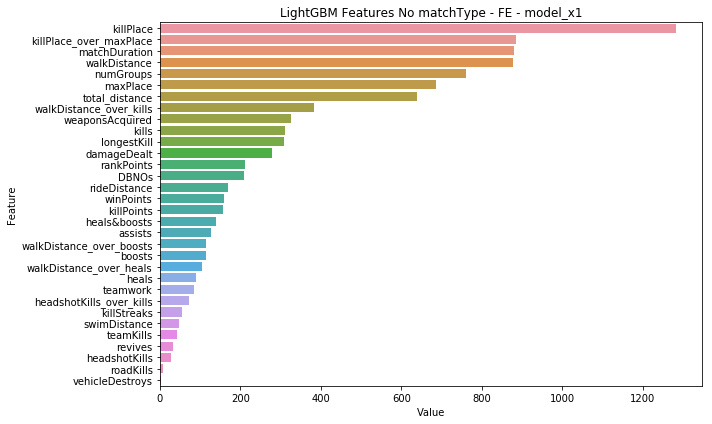

In [20]:
feature_importance = pd.DataFrame(sorted(zip(model_x1.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features No matchType - FE - model_x1')
plt.tight_layout()

In [14]:
mae_x1_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_x1_1 )
print(mae_x1_test)

12:20:55.245098
12:20:56.862630
1.61771s
0.05775875724021125


In [ ]:
 params2 = {
    'n_estimators': 32000,
    'learning_rate': 0.01, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1_2 = LGBMRegressor(**params2)
model_x1_2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=1000,
)
execution_time = ptime() - start
ptime2(execution_time)

In [12]:
params = {
    'n_estimators': 10000,
    'learning_rate': 0.3, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=1000,
)
execution_time = ptime() - start
ptime2(execution_time)

params2 = {
    'n_estimators': 32000,
    'learning_rate': 0.01, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1_2 = LGBMRegressor(**params2)
model_x1_2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=1000,
)
execution_time = ptime() - start
ptime2(execution_time)


04:53:28.122016
[1000]	valid_0's l1: 0.0567501
[2000]	valid_0's l1: 0.0562903
[3000]	valid_0's l1: 0.0560868
[4000]	valid_0's l1: 0.0559488
[5000]	valid_0's l1: 0.0558744
[6000]	valid_0's l1: 0.055816
[7000]	valid_0's l1: 0.0557962
[8000]	valid_0's l1: 0.055781
[9000]	valid_0's l1: 0.0557538
[10000]	valid_0's l1: 0.055734
05:23:12.961888
1784.839796s
05:23:12.962250
[1000]	valid_0's l1: 0.059795
[2000]	valid_0's l1: 0.0583179
[3000]	valid_0's l1: 0.0578583
[4000]	valid_0's l1: 0.0575921
[5000]	valid_0's l1: 0.0574225
[6000]	valid_0's l1: 0.0572831
[7000]	valid_0's l1: 0.0571788
[8000]	valid_0's l1: 0.0570767
[9000]	valid_0's l1: 0.0569928
[10000]	valid_0's l1: 0.0569089
[11000]	valid_0's l1: 0.056846
[12000]	valid_0's l1: 0.0567866
[13000]	valid_0's l1: 0.0567323
[14000]	valid_0's l1: 0.056679
[15000]	valid_0's l1: 0.0566261
[16000]	valid_0's l1: 0.0565782
[17000]	valid_0's l1: 0.0565316
[18000]	valid_0's l1: 0.0564852
[19000]	valid_0's l1: 0.0564407
[20000]	valid_0's l1: 0.0563986
[21

In [ ]:
mae_x1_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_x1)
print(mae_x1_train)

12:03:03.921070


In [ ]:
mae_x1_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_x1 )
print(mae_x1_test)

In [ ]:
feature_importance = pd.DataFrame(sorted(zip(model_x1.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features No matchType - FE - model_x1')
plt.tight_layout()